In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os 

In [2]:
from collections import Counter
from konlpy.tag import Mecab

In [3]:
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')

In [4]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 20000

In [6]:
# 토큰화 및 불용어 제거
def preprocess_text(text):

    tokens = tokenizer.morphs(text)  # Mecab 토큰화
    tokens = [word for word in tokens if word not in stopwords]  # 불용어 제거
    return tokens

# 단어 사전(word_to_index) 생성
def build_vocab(tokenized_texts, num_words):

    word_counts = Counter([word for tokens in tokenized_texts for word in tokens])  # 모든 단어의 빈도수 계산
    most_common_words = word_counts.most_common(num_words - 4)  # 가장 많이 등장하는 단어 추출 (-2는 PAD/OOV 고려)
    
    word_to_index = {word: idx + 4 for idx, (word, _) in enumerate(most_common_words)}  # 인덱스 부여 (2부터 시작)
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3
    return word_to_index

# 텍스트를 인덱스 시퀀스로 변환
def text_to_sequence(tokenized_texts, word_to_index):

    return [[word_to_index.get(word, 1) for word in tokens] for tokens in tokenized_texts]  # OOV 처리를 위해 get 사용

def load_data(train_data, test_data, num_words=num_words):

    # 1. 중복 데이터 제거
    train_data = train_data.drop_duplicates(subset=['document'])
    test_data = test_data.drop_duplicates(subset=['document'])

    # 2. NaN(결측치) 제거
    train_data = train_data.dropna(subset=['document'])
    test_data = test_data.dropna(subset=['document'])

    # 3. 토큰화 및 불용어 제거
    train_texts = [preprocess_text(text) for text in train_data['document']]
    test_texts = [preprocess_text(text) for text in test_data['document']]

    # 4. 단어 사전 생성
    word_to_index = build_vocab(train_texts, num_words)

    # 5. 텍스트를 인덱스 시퀀스로 변환
    X_train = text_to_sequence(train_texts, word_to_index)
    X_test = text_to_sequence(test_texts, word_to_index)

    # 6. 레이블 데이터 가져오기
    y_train = np.array(train_data['label'])
    y_test = np.array(test_data['label'])

    return X_train, y_train, X_test, y_test, word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
import matplotlib.pyplot as plt

최소 문장 길이: 0
최대 문장 길이: 116
평균 문장 길이: 15.97
상위 90% 문장의 최대 토큰 수: 33


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 53360 missing from current font.
  font.set_

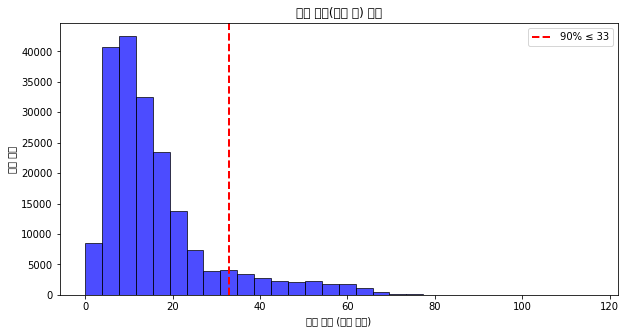

In [8]:
def visualize_sentence_lengths(X_train, X_test):
    """문장 길이(토큰 개수) 분포 시각화 및 통계 계산"""
    # 각 문장의 토큰 개수 계산
    train_lengths = [len(seq) for seq in X_train]
    test_lengths = [len(seq) for seq in X_test]
    
    # 훈련 데이터 & 테스트 데이터 문장 길이 합치기
    all_lengths = np.array(train_lengths + test_lengths)

    # 최소, 최대, 평균 문장 길이 출력
    min_len = np.min(all_lengths)
    max_len = np.max(all_lengths)
    avg_len = np.mean(all_lengths)
    percentile_90 = np.percentile(all_lengths, 90)  # 상위 90% 문장 길이
    
    print(f"최소 문장 길이: {min_len}")
    print(f"최대 문장 길이: {max_len}")
    print(f"평균 문장 길이: {avg_len:.2f}")
    print(f"상위 90% 문장의 최대 토큰 수: {percentile_90:.0f}")

    # 히스토그램 그리기
    plt.figure(figsize=(10, 5))
    plt.hist(all_lengths, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(percentile_90, color='red', linestyle='dashed', linewidth=2, label=f"90% ≤ {percentile_90:.0f}")
    plt.title("문장 길이(토큰 수) 분포")
    plt.xlabel("문장 길이 (토큰 개수)")
    plt.ylabel("문장 개수")
    plt.legend()
    plt.show()

# 시각화 실행
visualize_sentence_lengths(X_train, X_test)

In [9]:
def determine_sentence_length(X_train, X_test):
    """전체 문장의 90% 이상을 커버하는 문장 길이(토큰 수) 계산"""
    
    # 모든 문장의 길이(=토큰 수) 계산
    sentence_lengths = [len(sentence) for sentence in X_train + X_test]

    # 문장 길이 오름차순 정렬
    sorted_lengths = np.sort(sentence_lengths)

    # 누적 백분율 계산
    cumulative_percent = np.cumsum(sorted_lengths) / np.sum(sorted_lengths)

    # 90% 이상을 포함하는 문장 길이 찾기
    sentence_length_90 = sorted_lengths[np.argmax(cumulative_percent >= 0.90)]

    print(f"🔹 전체 문장의 90% 이상을 포함하는 문장 길이(토큰 수): {sentence_length_90}")

    return sentence_length_90

# 실행
sentence_length_90 = determine_sentence_length(X_train, X_test)

🔹 전체 문장의 90% 이상을 포함하는 문장 길이(토큰 수): 55


In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [11]:
len(index_to_word)

20000

In [12]:
maxlen = sentence_length_90

In [13]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

In [14]:
x_train.shape

(146182, 55)

In [15]:
# LSTM 모델

vocab_size = 20000
word_vector_dim = 50

model_LSTM = tf.keras.Sequential()

model_LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

model_LSTM.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_LSTM.add(tf.keras.layers.Dropout(0.1))  

model_LSTM.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_LSTM.add(tf.keras.layers.Dropout(0.1))

model_LSTM.add(tf.keras.layers.LSTM(32))

model_LSTM.add(tf.keras.layers.Dense(32, activation='relu'))
model_LSTM.add(tf.keras.layers.Dropout(0.1)) 
model_LSTM.add(tf.keras.layers.Dense(16, activation='relu'))
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 이진 분류

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         91648     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1

In [16]:
# 전체 학습데이터 중 20%는 몇개?
x_train.shape[0]*0.2

29236.4

In [17]:
val_index_num = 29236
X_val = x_train[:val_index_num]   
y_val = y_train[:val_index_num]

partial_X_train = x_train[val_index_num:]  
partial_y_train = y_train[val_index_num:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(116946, 55)
(116946,)
(29236, 55)
(29236,)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [19]:
# 콜백 함수 설정
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # 5 epoch 동안 개선되지 않으면 조기 종료
    ModelCheckpoint('LSTM_best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),  # 최적 모델 저장
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)  # 학습 정체 시 학습률 감소
]

# 모델 컴파일
model_LSTM.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

epochs = 50

# 모델 학습
history_LSTM = model_LSTM.fit(partial_X_train,
                              partial_y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              callbacks=callbacks,  # ✅ 콜백 추가
                              verbose=1)


Epoch 1/50
229/229 [==============================] - 11s 26ms/step - loss: 0.4464 - accuracy: 0.7805 - val_loss: 0.3476 - val_accuracy: 0.8510
Epoch 2/50
229/229 [==============================] - 5s 22ms/step - loss: 0.3151 - accuracy: 0.8684 - val_loss: 0.3359 - val_accuracy: 0.8562
Epoch 3/50
229/229 [==============================] - 5s 22ms/step - loss: 0.2712 - accuracy: 0.8889 - val_loss: 0.3347 - val_accuracy: 0.8581
Epoch 4/50
229/229 [==============================] - 5s 22ms/step - loss: 0.2347 - accuracy: 0.9063 - val_loss: 0.3485 - val_accuracy: 0.8584
Epoch 5/50
229/229 [==============================] - 5s 22ms/step - loss: 0.2017 - accuracy: 0.9218 - val_loss: 0.3987 - val_accuracy: 0.8549
Epoch 6/50
229/229 [==============================] - 5s 22ms/step - loss: 0.1718 - accuracy: 0.9348 - val_loss: 0.4143 - val_accuracy: 0.8513

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
229/229 [==============================] - 5s 22m

In [20]:
best_model_LSTM = load_model('LSTM_best_model.h5')

# 테스트 데이터 평가
results_LSTM = best_model_LSTM.evaluate(x_test, y_test, verbose=2)

# 평가 결과 출력
print(f"Test Loss: {results_LSTM[0]:.4f}")
print(f"Test Accuracy: {results_LSTM[1]:.4f}")

1537/1537 - 7s - loss: 0.3436 - accuracy: 0.8538
Test Loss: 0.3436
Test Accuracy: 0.8538


In [21]:
history_dict_LSTM = history_LSTM.history

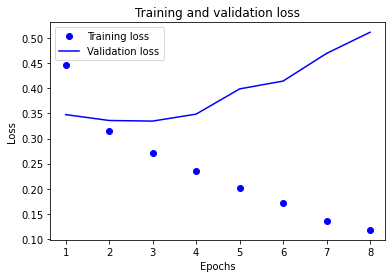

In [22]:
acc = history_dict_LSTM['accuracy']
val_acc = history_dict_LSTM['val_accuracy']
loss = history_dict_LSTM['loss']
val_loss = history_dict_LSTM['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
# GRU 모델

model_GRU = tf.keras.Sequential()

# Embedding Layer
model_GRU.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

model_GRU.add(tf.keras.layers.GRU(128, return_sequences=True))
model_GRU.add(tf.keras.layers.Dropout(0.1))

model_GRU.add(tf.keras.layers.GRU(64, return_sequences=True))
model_GRU.add(tf.keras.layers.Dropout(0.1))

model_GRU.add(tf.keras.layers.GRU(32))

# Fully Connected Layers
model_GRU.add(tf.keras.layers.Dense(32, activation='relu'))
model_GRU.add(tf.keras.layers.Dropout(0.1))
model_GRU.add(tf.keras.layers.Dense(16, activation='relu'))
model_GRU.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 이진 분류

# 모델 요약
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
gru (GRU)                    (None, None, 128)         69120     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 64)          37248     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

In [24]:
# 콜백 함수 설정
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # 5 epoch 동안 개선되지 않으면 조기 종료
    ModelCheckpoint('GRU_best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),  # 최적 모델 저장
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)  # 학습 정체 시 학습률 감소
]

# 모델 컴파일
model_GRU.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

epochs = 50

# 모델 학습
history_GRU = model_GRU.fit(partial_X_train,
                              partial_y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              callbacks=callbacks,  # ✅ 콜백 추가
                              verbose=1)

Epoch 1/50
229/229 [==============================] - 9s 25ms/step - loss: 0.4208 - accuracy: 0.8061 - val_loss: 0.3493 - val_accuracy: 0.8501
Epoch 2/50
229/229 [==============================] - 5s 20ms/step - loss: 0.3182 - accuracy: 0.8676 - val_loss: 0.3456 - val_accuracy: 0.8526
Epoch 3/50
229/229 [==============================] - 5s 20ms/step - loss: 0.2843 - accuracy: 0.8845 - val_loss: 0.3462 - val_accuracy: 0.8550
Epoch 4/50
229/229 [==============================] - 5s 20ms/step - loss: 0.2519 - accuracy: 0.8997 - val_loss: 0.3549 - val_accuracy: 0.8562
Epoch 5/50
229/229 [==============================] - 5s 20ms/step - loss: 0.2223 - accuracy: 0.9121 - val_loss: 0.3600 - val_accuracy: 0.8513

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
229/229 [==============================] - 5s 20ms/step - loss: 0.1789 - accuracy: 0.9324 - val_loss: 0.4129 - val_accuracy: 0.8508
Epoch 7/50
229/229 [==============================] - 5s 20ms

In [25]:
best_model_GRU = load_model('GRU_best_model.h5')

# 테스트 데이터 평가
results_GRU = best_model_GRU.evaluate(x_test, y_test, verbose=2)

# 평가 결과 출력
print(f"Test Loss: {results_GRU[0]:.4f}")
print(f"Test Accuracy: {results_GRU[1]:.4f}")

1537/1537 - 6s - loss: 0.3562 - accuracy: 0.8465
Test Loss: 0.3562
Test Accuracy: 0.8465


In [26]:
history_dict_GRU = history_GRU.history

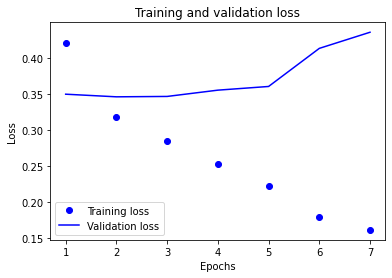

In [27]:
acc = history_dict_GRU['accuracy']
val_acc = history_dict_GRU['val_accuracy']
loss = history_dict_GRU['loss']
val_loss = history_dict_GRU['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [28]:
# 1D합성곱 모델

model_1dConv = tf.keras.Sequential()

# 임베딩 레이어
model_1dConv.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=None))

# 첫 번째 Conv1D 레이어
model_1dConv.add(tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'))
model_1dConv.add(tf.keras.layers.MaxPooling1D(2))

# 두 번째 Conv1D 레이어
model_1dConv.add(tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'))
model_1dConv.add(tf.keras.layers.MaxPooling1D(2))

# 세 번째 Conv1D 레이어 (더 깊게 만들기)
model_1dConv.add(tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same'))
model_1dConv.add(tf.keras.layers.MaxPooling1D(2))

# 네 번째 Conv1D 레이어 (더 깊게 만들기)
model_1dConv.add(tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same'))
model_1dConv.add(tf.keras.layers.MaxPooling1D(2))

# GlobalAveragePooling1D
model_1dConv.add(tf.keras.layers.GlobalAveragePooling1D())

# Dense 레이어
model_1dConv.add(tf.keras.layers.Dense(32, activation='relu'))
model_1dConv.add(tf.keras.layers.Dropout(0.1))  # Dropout 레이어 추가로 과적합 방지

model_1dConv.add(tf.keras.layers.Dense(16, activation='relu'))

# 최종 출력층
model_1dConv.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 이진 분류

# 모델 요약
model_1dConv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         32128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          41024     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)         

In [29]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # 5 epoch 동안 개선되지 않으면 조기 종료
    ModelCheckpoint('1dConv_best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),  # 최적 모델 저장
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)  # 학습 정체 시 학습률 감소
]

# 모델 컴파일
model_1dConv.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

epochs = 50

# 모델 학습
history_1dConv = model_1dConv.fit(partial_X_train,
                              partial_y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val, y_val),
                              callbacks=callbacks,  # ✅ 콜백 추가
                              verbose=1)

Epoch 1/50
229/229 [==============================] - 6s 16ms/step - loss: 0.4404 - accuracy: 0.7837 - val_loss: 0.3344 - val_accuracy: 0.8523
Epoch 2/50
229/229 [==============================] - 3s 13ms/step - loss: 0.2907 - accuracy: 0.8803 - val_loss: 0.3226 - val_accuracy: 0.8625
Epoch 3/50
229/229 [==============================] - 3s 13ms/step - loss: 0.2288 - accuracy: 0.9096 - val_loss: 0.3479 - val_accuracy: 0.8621
Epoch 4/50
229/229 [==============================] - 3s 13ms/step - loss: 0.1666 - accuracy: 0.9385 - val_loss: 0.4192 - val_accuracy: 0.8531
Epoch 5/50
229/229 [==============================] - 3s 13ms/step - loss: 0.1156 - accuracy: 0.9596 - val_loss: 0.4736 - val_accuracy: 0.8516

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0652 - accuracy: 0.9800 - val_loss: 0.5901 - val_accuracy: 0.8498
Epoch 7/50
229/229 [==============================] - 3s 14ms

In [30]:
best_model_1dConv = load_model('1dConv_best_model.h5')

# 테스트 데이터 평가
results_1dConv = best_model_1dConv.evaluate(x_test, y_test, verbose=2)

# 평가 결과 출력
print(f"Test Loss: {results_1dConv[0]:.4f}")
print(f"Test Accuracy: {results_1dConv[1]:.4f}")

1537/1537 - 3s - loss: 0.3326 - accuracy: 0.8561
Test Loss: 0.3326
Test Accuracy: 0.8561


In [31]:
history_dict_1dConv = history_1dConv.history

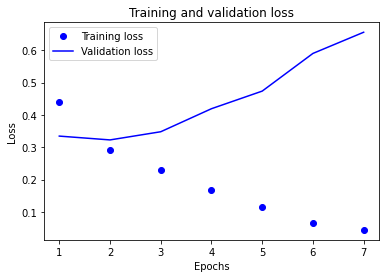

In [32]:
acc = history_dict_1dConv['accuracy']
val_acc = history_dict_1dConv['val_accuracy']
loss = history_dict_1dConv['loss']
val_loss = history_dict_1dConv['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 모델별 성능 비교 결과 
### 1. LSTM 모델 
##### - 총 파라미터 수 : 1,155,073
##### - 테스트 정확도 : 85.38%
#### 
### 2. GRU 모델 
##### - 총 파라미터 수 : 1,117,377
##### - 테스트 정확도 : 84.65%
#### 
### 3. 1D합성곱 모델 
##### - 총 파라미터 수 : 1,167,073
##### - 테스트 정확도 : 85.61%

In [33]:
# 가장 정확도 높은 1D합성곱 모델의 임베딩 벡터 활용
embedding_layer = model_1dConv.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(20000, 50)


In [34]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'word2vec_1dConv.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_1dConv.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [35]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

from gensim.models import KeyedVectors


In [36]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['여왕']
vector

array([-0.0524366 ,  0.06418271, -0.01607423, -0.02424447,  0.01545665,
        0.0369083 ,  0.06428412, -0.00753321, -0.02214317, -0.00903156,
        0.0020891 , -0.02446234, -0.00358015,  0.00645151, -0.01577192,
        0.00459402,  0.00087584,  0.00353131, -0.05759848,  0.00739267,
       -0.03162974,  0.04140215,  0.04931647,  0.06424895,  0.04269435,
        0.04379002, -0.03312357,  0.05969759,  0.01848337, -0.04733563,
        0.00563667,  0.00768246, -0.00710767, -0.01524821,  0.03253279,
       -0.04977069,  0.00408659,  0.03865075,  0.01297363, -0.04469583,
        0.05551972,  0.00365604, -0.08685186, -0.04368478,  0.0108751 ,
        0.02209339, -0.03166053, -0.02524791, -0.02996854,  0.03702734],
      dtype=float32)

In [37]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([ 0.07083329, -0.064479  ,  0.04206255, -0.00118136, -0.05968733,
       -0.00051479, -0.00297695, -0.03077257,  0.0204783 , -0.0249656 ,
       -0.01489196,  0.0076211 ,  0.01641693,  0.06280059,  0.04098829,
        0.06796412,  0.02847155, -0.0500152 ,  0.02499795,  0.00693472,
        0.05720198, -0.01794033, -0.02755588, -0.06478557, -0.05236019,
       -0.05969116, -0.04081917, -0.02944829,  0.00220309, -0.02626917,
        0.03268557,  0.02768672, -0.01679914, -0.00349175, -0.06991927,
        0.11991997, -0.04631865,  0.00656322, -0.02975681,  0.03362911,
        0.03107117,  0.02885118,  0.03074548,  0.03919529, -0.07345978,
        0.00340701,  0.07440536,  0.09136052,  0.01406544, -0.01693277],
      dtype=float32)

In [38]:
# 영화감정 리뷰 안에 등장할만한 단어들은 어느정도 비슷한 유의어 추출 성능을 보임
word_vectors.similar_by_word("기쁨")

[('엄청난', 0.7245993614196777),
 ('아즈', 0.6992539763450623),
 ('여잔데', 0.6931589841842651),
 ('젊은이', 0.6738961338996887),
 ('느껴집니다', 0.6664799451828003),
 ('공연', 0.6664738655090332),
 ('극사실주의', 0.6609975099563599),
 ('눈부시', 0.6545071601867676),
 ('맞물려', 0.6507154703140259),
 ('어영', 0.6502725481987)]

In [39]:
word_vectors.similar_by_word("감동")

[('이어주', 0.8075467944145203),
 ('사명감', 0.7766427993774414),
 ('간만에', 0.7739025950431824),
 ('적절히', 0.7673519253730774),
 ('상큼', 0.7666521668434143),
 ('♥♥', 0.7570741176605225),
 ('Good', 0.7553259134292603),
 ('♡', 0.7504222393035889),
 ('ㅜㅜㅜ', 0.7444486618041992),
 ('생생히', 0.7430229783058167)]

In [40]:
# 영화 감정리뷰과 관련 없는 단어들은 유의어 추출 성능 별로임
word_vectors.similar_by_word("여왕")

[('홍보물', 0.650307834148407),
 ('엽기', 0.6424819231033325),
 ('독수리', 0.6367419958114624),
 ('화내', 0.631841778755188),
 ('파티', 0.6278703808784485),
 ('윤시윤', 0.6276612281799316),
 ('아녀', 0.6274198293685913),
 ('수준', 0.6254639625549316),
 ('신비주의', 0.6254586577415466),
 ('어설퍼', 0.619318962097168)]

In [41]:
word_vectors.similar_by_word("바보")

[('격조', 0.5605752468109131),
 ('화합', 0.5569058656692505),
 ('칠', 0.5207974314689636),
 ('수배', 0.5078892111778259),
 ('눈치채', 0.507129430770874),
 ('04', 0.5053106546401978),
 ('박영규', 0.5049431920051575),
 ('도망갈', 0.5002546310424805),
 ('순금', 0.49737003445625305),
 ('뺴곤', 0.4948672354221344)]

In [42]:
word_vectors.similar_by_word("nice")

[('포용', 0.6795049905776978),
 ('노을', 0.6550917625427246),
 ('제니퍼코넬리', 0.6453461647033691),
 ('어우러진', 0.642565906047821),
 ('이슬람', 0.6419686079025269),
 ('첩혈쌍웅', 0.6418551802635193),
 ('서늘', 0.6367620825767517),
 ('들려', 0.6330897808074951),
 ('아이즈', 0.6308884024620056),
 ('테이크', 0.6306036114692688)]